<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-библиотек" data-toc-modified-id="Загрузка-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка библиотек</a></span></li><li><span><a href="#Загрузка-датасета" data-toc-modified-id="Загрузка-датасета-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка датасета</a></span></li><li><span><a href="#Подготовка-признаков-перед-обучением" data-toc-modified-id="Подготовка-признаков-перед-обучением-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Подготовка признаков перед обучением</a></span></li><li><span><a href="#Изменение-баланса-классов" data-toc-modified-id="Изменение-баланса-классов-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Изменение баланса классов</a></span><ul class="toc-item"><li><span><a href="#Изменение-весов-классов" data-toc-modified-id="Изменение-весов-классов-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Изменение весов классов</a></span></li><li><span><a href="#Ресемплирование-с-уменьшением-класса-0" data-toc-modified-id="Ресемплирование-с-уменьшением-класса-0-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Ресемплирование с уменьшением класса 0</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#SGDClassifier" data-toc-modified-id="SGDClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>SGDClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Загрузка библиотек

In [1]:
#!pip install fastcore -U

In [2]:
#pip install wordcloud

In [3]:
#import sys
#!{sys.executable} -m pip install spacy
#!{sys.executable} -m spacy download en

In [4]:
from wordcloud import WordCloud

In [5]:
#!{sys.executable} -m pip install --upgrade pip
#!{sys.executable} -m pip install --upgrade Pillow


In [6]:
import nltk
import spacy

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import plotly.graph_objects as go
import re
import time

from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline


import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE=12345
CV_COUNTS = 3

### Загрузка датасета

In [8]:
try:
    df = pd.read_csv('toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [9]:
display(df['toxic'].value_counts())
class_ratio = df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1]
class_ratio

0    143106
1     16186
Name: toxic, dtype: int64

8.841344371679229

In [10]:
df.info()
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,text,toxic
89621,"""\n\nTo be honest, I don't really see the poin...",0
62429,"""{| style=""""background-color:#F5FFFA; padding:...",0
19211,"""\n\n Ted Kennedy death is hilarious? \n\nHe i...",0
111271,"Hi Ancapp. For the time being, I'd rather focu...",0
132294,""" ps: I have to admit that """"childish"""" and """"...",0
108236,Re Hinduism and Science \n\nIts hard to see h...,0
94887,"""\n\nOkay, thanks. I am doing very little edit...",0
1943,"If the LAW is a single use weapon, isn't this ...",0
11529,Sources for Rome population \n\nCould someone ...,0
135377,Many thanks & apologies to others who have com...,0


In [11]:
df.isna().sum()

text     0
toxic    0
dtype: int64

In [12]:
y = df['toxic'].copy()
y.value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

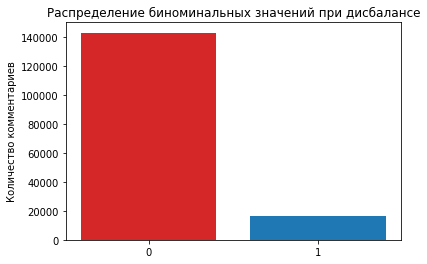

In [13]:
fig, ax = plt.subplots()

toxic = ['0', '1']
counts = [df['toxic'].value_counts()[0], df['toxic'].value_counts()[1]]
bar_colors = ['tab:red', 'tab:blue']

ax.bar(toxic, counts, color=bar_colors)

ax.set_ylabel('Количество комментариев')
ax.set_title('Распределение биноминальных значений при дисбалансе')

plt.show()

- Соотношение токсчиных комментариев к обычным: 1 : 9

- Всего комментариев ~ 160 тыс.

Классы несбалансированы. Проведем поиск лучшего способа балансировки и сравним качество.

- Изменение весов в модели обучения
- Ресемплирование с уменьшением класса 0

Ресемплирование с увеличением класса 1 не будем использовать из-за большого набора данных.

In [14]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r"(\w)(\1{2,})","\\1",text,flags=re.MULTILINE) #Удаление из комментария повторяющихся символов
    text = re.sub(r"[\n\t\\\/]"," ",text, flags=re.MULTILINE) #комментарии типа «\ n», «\ t», «/» и «\».
    text = re.sub(r'\d'," ",text, flags=re.MULTILINE) #удаление цифр из комментария
    text = re.sub(r"<.*>"," ",text, flags=re.MULTILINE) # удаление HTML-тегов из комментария
    text = text.strip(' ')
    return text


In [15]:
tqdm.pandas()
df['text'] = df['text'].progress_apply(clean_text)

100%|██████████| 159292/159292 [00:12<00:00, 12403.09it/s]


### Подготовка признаков перед обучением

In [16]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
def spacy_lemm(sentence):
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc])

df['lemm_text'] = df['text'].progress_apply(spacy_lemm)

100%|██████████| 159292/159292 [15:36<00:00, 170.05it/s]


**WordCloud**

In [17]:
data_toxic = df.loc[df['toxic']==1].copy()
text_raw = " ".join(data_toxic['lemm_text'])
wordcloud_toxic = WordCloud(collocations=False).generate(text_raw)

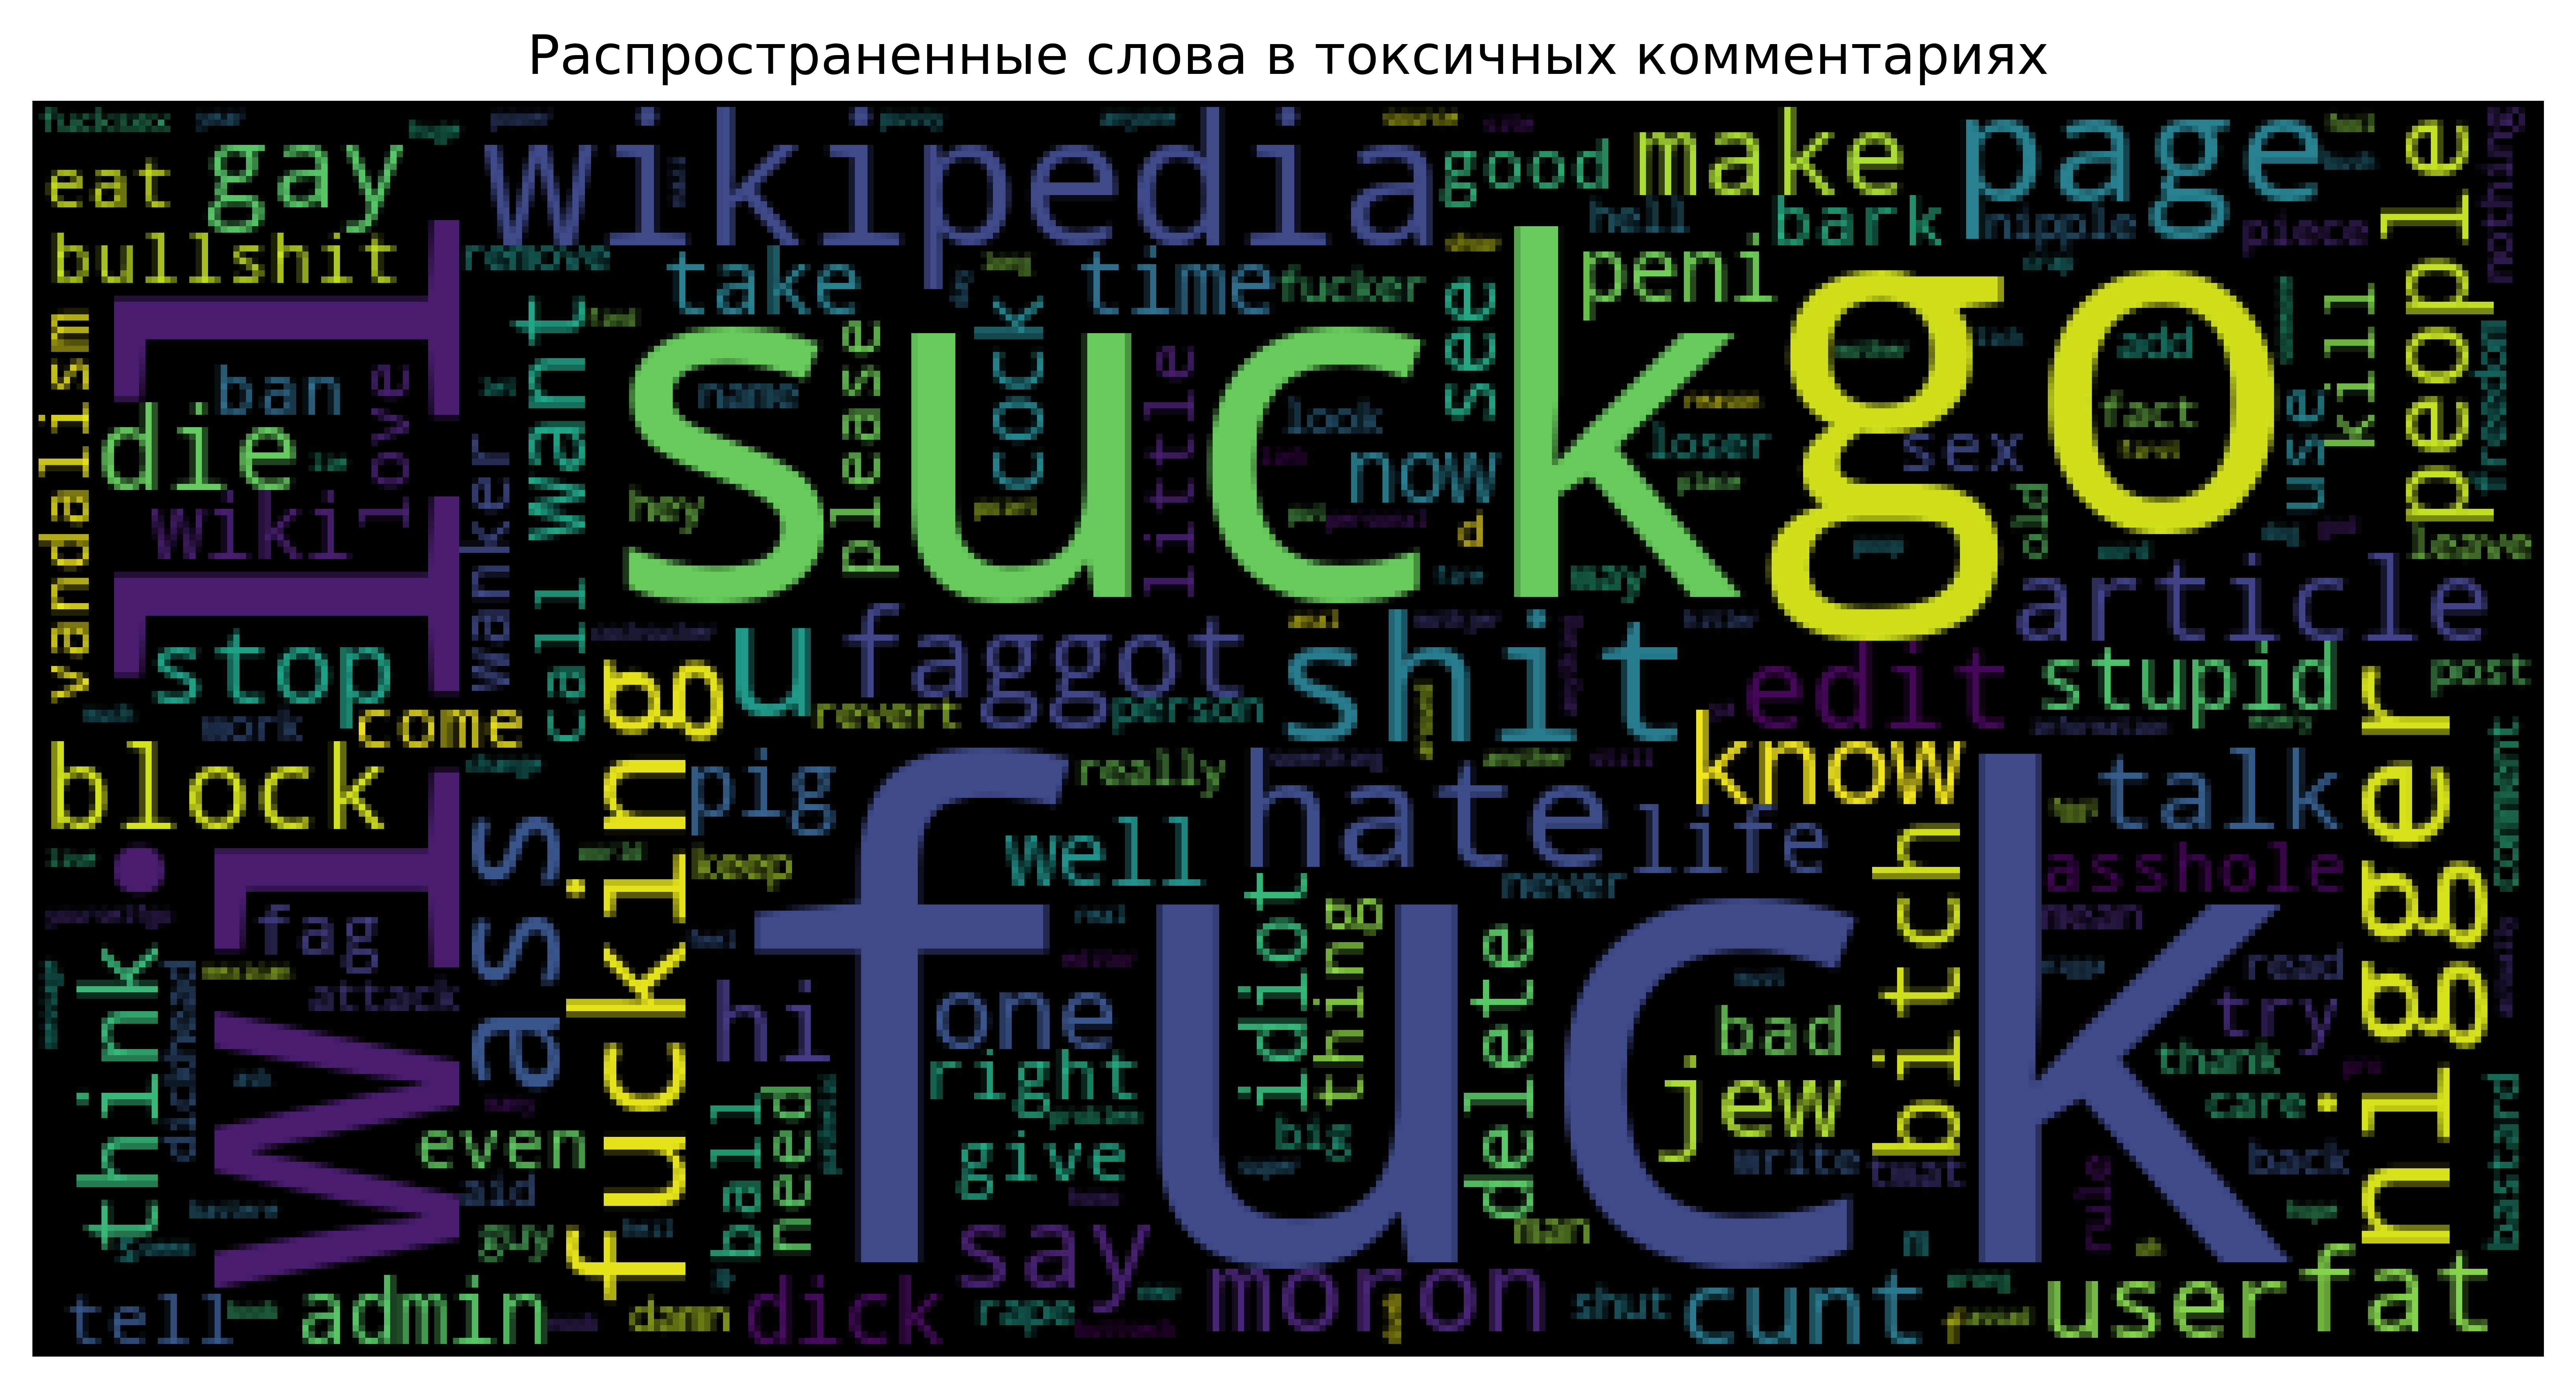

In [18]:
plt.figure(figsize=(10,10), dpi=1000)
plt.imshow(wordcloud_toxic)
plt.title('Распространенные слова в токсичных комментариях')
plt.axis('off')
plt.show()

In [19]:
data_positive = df.loc[df['toxic']==0].copy()
text_raw = " ".join(data_positive['lemm_text'])
wordcloud_positive = WordCloud(collocations=False).generate(text_raw)

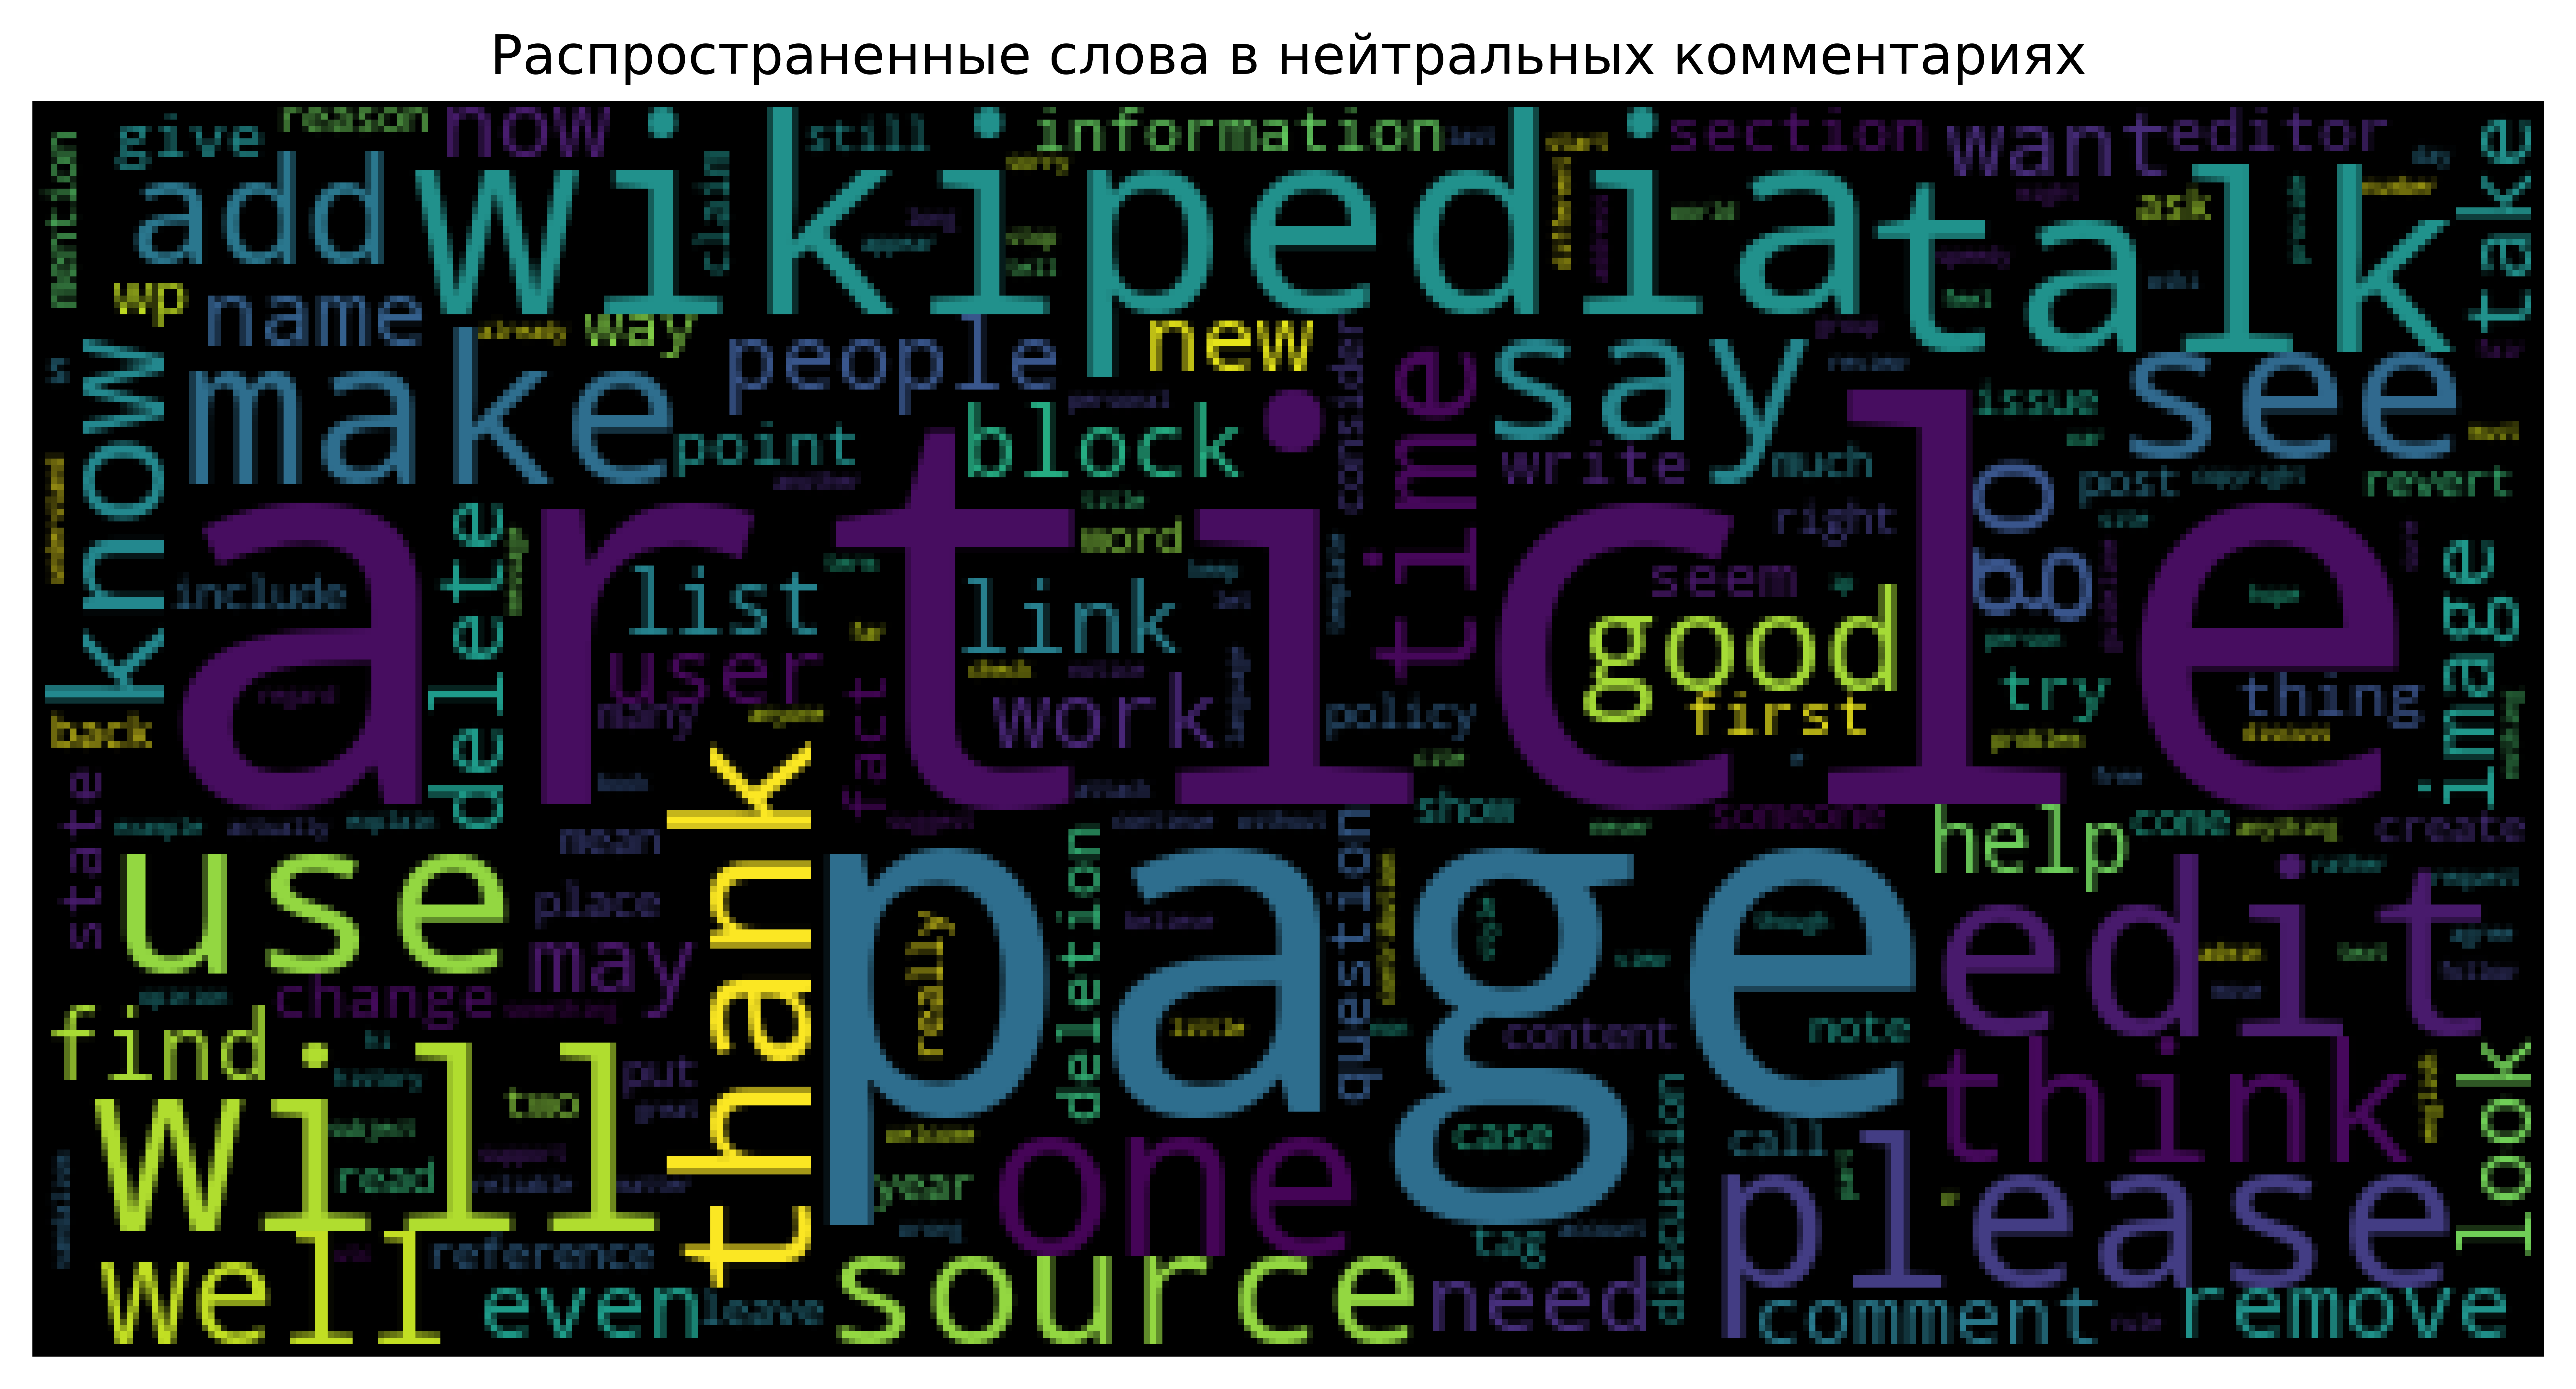

In [20]:
plt.figure(figsize=(10,10), dpi=1000)
plt.imshow(wordcloud_positive)
plt.title('Распространенные слова в нейтральных комментариях')
plt.axis('off')
plt.show()

Разобьем выборку в соотношении 4:1. Уменьшим количество кроссвалидаций до 3.

In [21]:
'''

y = df['toxic']
X = df.drop(['toxic'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=RANDOM_STATE, stratify=y)


nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

X_train = count_tf_idf.fit_transform(X_train['lemm_text'])
X_test = count_tf_idf.transform(X_test['lemm_text'])
print(X_train.shape)
print(X_test.shape)
'''


"\n\ny = df['toxic']\nX = df.drop(['toxic'], axis=1)\n\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=RANDOM_STATE, stratify=y)\n\n\nnltk.download('stopwords')\nstopwords = set(nltk_stopwords.words('english'))\n\ncount_tf_idf = TfidfVectorizer(stop_words=stopwords)\n\nX_train = count_tf_idf.fit_transform(X_train['lemm_text'])\nX_test = count_tf_idf.transform(X_test['lemm_text'])\nprint(X_train.shape)\nprint(X_test.shape)\n"

In [22]:
'''

%%time

classificator = LogisticRegression(random_state=RANDOM_STATE)
train_f1 = cross_val_score(classificator, 
                      X_train, 
                      y_train, 
                      cv=CV_COUNTS, 
                      scoring='f1').mean()
print('F1 на CV', train_f1)
'''

"\n\n%%time\n\nclassificator = LogisticRegression(random_state=RANDOM_STATE)\ntrain_f1 = cross_val_score(classificator, \n                      X_train, \n                      y_train, \n                      cv=CV_COUNTS, \n                      scoring='f1').mean()\nprint('F1 на CV', train_f1)\n"

### Изменение баланса классов

#### Изменение весов классов

Проверим, как работает встроенный метод, будет ли он повторять значение F1 при ручном методе.

In [23]:
'''
%%time

dict_classes={0:1, 1:class_ratio}
classificator = LogisticRegression(random_state=RANDOM_STATE, class_weight=dict_classes)
train_f1_balanced = cross_val_score(classificator, 
                                    X_train, 
                                    y_train, 
                                    cv=CV_COUNTS, 
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_balanced)
'''

"\n%%time\n\ndict_classes={0:1, 1:class_ratio}\nclassificator = LogisticRegression(random_state=RANDOM_STATE, class_weight=dict_classes)\ntrain_f1_balanced = cross_val_score(classificator, \n                                    X_train, \n                                    y_train, \n                                    cv=CV_COUNTS, \n                                    scoring='f1').mean()\nprint('F1 на CV с балансированными классами', train_f1_balanced)\n"

In [24]:
'''
%%time

classificator = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')
train_f1_balanced = cross_val_score(classificator, 
                                    X_train, 
                                    y_train, 
                                    cv=CV_COUNTS, 
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_balanced)
'''

"\n%%time\n\nclassificator = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')\ntrain_f1_balanced = cross_val_score(classificator, \n                                    X_train, \n                                    y_train, \n                                    cv=CV_COUNTS, \n                                    scoring='f1').mean()\nprint('F1 на CV с балансированными классами', train_f1_balanced)\n"

На обучающей выборке F1-мера увеличилась. Встроенный метод показывает значение F1 ниже.

#### Ресемплирование с уменьшением класса 0

Сделаем количество записей с классом 0 таким же, как и количество записей с классом 1.

In [25]:
'''
toxic_comments_train = df.loc[y_train.index]

y_train_class_zero = toxic_comments_train[toxic_comments_train['toxic'] == 0]['toxic']
y_train_class_one = toxic_comments_train[toxic_comments_train['toxic'] == 1]['toxic']
'''


"\ntoxic_comments_train = df.loc[y_train.index]\n\ny_train_class_zero = toxic_comments_train[toxic_comments_train['toxic'] == 0]['toxic']\ny_train_class_one = toxic_comments_train[toxic_comments_train['toxic'] == 1]['toxic']\n"

In [26]:
'''
y_train_class_zero_downsample = y_train_class_zero.sample(y_train_class_one.shape[0],
                                                                    random_state=RANDOM_STATE)
y_train_downsample = pd.concat([y_train_class_zero_downsample, y_train_class_one])

X_train_downsample = df.loc[y_train_downsample.index]
X_train_downsample, y_train_downsample = shuffle(X_train_downsample,
                                                 y_train_downsample,
                                                 random_state=RANDOM_STATE)
X_train_downsample = count_tf_idf.transform(X_train_downsample['lemm_text'])
del count_tf_idf
'''


"\ny_train_class_zero_downsample = y_train_class_zero.sample(y_train_class_one.shape[0],\n                                                                    random_state=RANDOM_STATE)\ny_train_downsample = pd.concat([y_train_class_zero_downsample, y_train_class_one])\n\nX_train_downsample = df.loc[y_train_downsample.index]\nX_train_downsample, y_train_downsample = shuffle(X_train_downsample,\n                                                 y_train_downsample,\n                                                 random_state=RANDOM_STATE)\nX_train_downsample = count_tf_idf.transform(X_train_downsample['lemm_text'])\ndel count_tf_idf\n"

In [27]:
'''
classificator = LogisticRegression(random_state=RANDOM_STATE)
train_f1_downsampled = cross_val_score(classificator,
                      X_train_downsample, 
                      y_train_downsample, 
                      cv=CV_COUNTS, 
                      scoring='f1').mean()
print('F1 на CV с уменьшением классов', train_f1_downsampled)
'''

"\nclassificator = LogisticRegression(random_state=RANDOM_STATE)\ntrain_f1_downsampled = cross_val_score(classificator,\n                      X_train_downsample, \n                      y_train_downsample, \n                      cv=CV_COUNTS, \n                      scoring='f1').mean()\nprint('F1 на CV с уменьшением классов', train_f1_downsampled)\n"

C ресемплированием прирост F1-меры стал ощутимее.

Построим ROC-AUC графики и просмотрим таблицу результатов баллансирования.

**Линейная регрессия без баланса классов.**

In [28]:
'''
pipe_lr = make_pipeline(
    LogisticRegression(
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
)
lr_params = {
    'logisticregression__max_iter':[200]
}

lr_gs_f1 = GridSearchCV(
    pipe_lr,
    lr_params,
    scoring={'roc_auc':'roc_auc', 'f1':'f1'},
    n_jobs=-1,
    verbose=1,
    refit='f1'
)
%time lr_f1 = lr_gs_f1.fit(X_train, y_train)
print('Среднее значение F1 при кросс-валидации:', '{:.4f}'.format(cross_val_score(lr_f1, X_train, y_train, cv=CV_COUNTS, scoring='f1').mean()))
'''

"\npipe_lr = make_pipeline(\n    LogisticRegression(\n        random_state=RANDOM_STATE,\n        n_jobs=-1\n    )\n)\nlr_params = {\n    'logisticregression__max_iter':[200]\n}\n\nlr_gs_f1 = GridSearchCV(\n    pipe_lr,\n    lr_params,\n    scoring={'roc_auc':'roc_auc', 'f1':'f1'},\n    n_jobs=-1,\n    verbose=1,\n    refit='f1'\n)\n%time lr_f1 = lr_gs_f1.fit(X_train, y_train)\nprint('Среднее значение F1 при кросс-валидации:', '{:.4f}'.format(cross_val_score(lr_f1, X_train, y_train, cv=CV_COUNTS, scoring='f1').mean()))\n"

In [29]:
'''
print('Лучший F1 на обучающей выборке:','{:.4f}'.format(lr_f1.score(X_train, y_train)))
print('Лучший F1 на тестовой выборке:','{:.4f}'.format(lr_f1.score(X_test, y_test)))
'''

"\nprint('Лучший F1 на обучающей выборке:','{:.4f}'.format(lr_f1.score(X_train, y_train)))\nprint('Лучший F1 на тестовой выборке:','{:.4f}'.format(lr_f1.score(X_test, y_test)))\n"

In [30]:
#predicted_test_lr = lr_f1.predict(X_test)

In [31]:
#lr_fpr, lr_tpr, thresholds = roc_curve(y_test, lr_f1.predict_proba(X_test)[:,1])

**Линейная регрессия с балансом классов.**

In [32]:
'''
pipe_lr = make_pipeline(
    LogisticRegression(
        random_state=RANDOM_STATE,
        class_weight='balanced',
        n_jobs=-1
    )
)
lr_params = {
    'logisticregression__max_iter':[200]
}

lr_gs_f1 = GridSearchCV(
    pipe_lr,
    lr_params,
    scoring={'roc_auc':'roc_auc', 'f1':'f1'},
    n_jobs=-1,
    verbose=1,
    refit='f1'
)
%time lr_f1_balanced = lr_gs_f1.fit(X_train, y_train)
print('Среднее значение F1 при кросс-валидации:', '{:.4f}'.format(cross_val_score(lr_f1_balanced, X_train, y_train, cv=CV_COUNTS, scoring='f1').mean()))
'''

"\npipe_lr = make_pipeline(\n    LogisticRegression(\n        random_state=RANDOM_STATE,\n        class_weight='balanced',\n        n_jobs=-1\n    )\n)\nlr_params = {\n    'logisticregression__max_iter':[200]\n}\n\nlr_gs_f1 = GridSearchCV(\n    pipe_lr,\n    lr_params,\n    scoring={'roc_auc':'roc_auc', 'f1':'f1'},\n    n_jobs=-1,\n    verbose=1,\n    refit='f1'\n)\n%time lr_f1_balanced = lr_gs_f1.fit(X_train, y_train)\nprint('Среднее значение F1 при кросс-валидации:', '{:.4f}'.format(cross_val_score(lr_f1_balanced, X_train, y_train, cv=CV_COUNTS, scoring='f1').mean()))\n"

In [33]:
#print('Лучший F1 на обучающей выборке:','{:.4f}'.format(lr_f1_balanced.score(X_train, y_train)))
#print('Лучший F1 на тестовой выборке:','{:.4f}'.format(lr_f1_balanced.score(X_test, y_test)))

In [34]:
#predicted_test_lr = lr_f1_balanced.predict(X_test)

In [35]:
#lr_fpr_balanced, lr_tpr_balanced, thresholds = roc_curve(y_test, lr_f1_balanced.predict_proba(X_test)[:,1])

**Линейная регрессия с уменьшением класса 0**

In [36]:
'''
pipe_lr = make_pipeline(
    LogisticRegression(
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
)
lr_params = {
    'logisticregression__max_iter':[200]
}

lr_gs_f1 = GridSearchCV(
    pipe_lr,
    lr_params,
    scoring={'roc_auc':'roc_auc', 'f1':'f1'},
    n_jobs=-1,
    verbose=1,
    refit='f1'
)
%time lr_f1_downsample = lr_gs_f1.fit(X_train_downsample, y_train_downsample)
print('Среднее значение F1 при кросс-валидации:', '{:.4f}'.format(cross_val_score(lr_f1_downsample, X_train_downsample, y_train_downsample, cv=CV_COUNTS, scoring='f1').mean()))
'''

"\npipe_lr = make_pipeline(\n    LogisticRegression(\n        random_state=RANDOM_STATE,\n        n_jobs=-1\n    )\n)\nlr_params = {\n    'logisticregression__max_iter':[200]\n}\n\nlr_gs_f1 = GridSearchCV(\n    pipe_lr,\n    lr_params,\n    scoring={'roc_auc':'roc_auc', 'f1':'f1'},\n    n_jobs=-1,\n    verbose=1,\n    refit='f1'\n)\n%time lr_f1_downsample = lr_gs_f1.fit(X_train_downsample, y_train_downsample)\nprint('Среднее значение F1 при кросс-валидации:', '{:.4f}'.format(cross_val_score(lr_f1_downsample, X_train_downsample, y_train_downsample, cv=CV_COUNTS, scoring='f1').mean()))\n"

In [37]:
#print('Лучший F1 на обучающей выборке:','{:.4f}'.format(lr_f1_downsample.score(X_train_downsample, y_train_downsample)))
#print('Лучший F1 на тестовой выборке:','{:.4f}'.format(lr_f1_downsample.score(X_test, y_test)))

In [38]:
#predicted_test_lr = lr_f1_downsample.predict(X_test)

In [39]:
#lr_fpr_downsample, lr_tpr_downsample, thresholds = roc_curve(y_test, lr_f1_downsample.predict_proba(X_test)[:,1])

In [40]:
'''

plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')

plt.plot(lr_fpr, lr_tpr, label='ЛинРег')

plt.plot(lr_fpr_balanced, lr_tpr_balanced, label='ЛинРег - Баланс классов')

plt.plot(lr_fpr_downsample, lr_tpr_downsample, label='ЛинРег - Ресемпл')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()
'''

'\n\nplt.figure(figsize=[12,9])\n\nplt.plot([0, 1], [0, 1], linestyle=\'--\', label=\'Случайная модель\')\n\nplt.plot(lr_fpr, lr_tpr, label=\'ЛинРег\')\n\nplt.plot(lr_fpr_balanced, lr_tpr_balanced, label=\'ЛинРег - Баланс классов\')\n\nplt.plot(lr_fpr_downsample, lr_tpr_downsample, label=\'ЛинРег - Ресемпл\')\n\nplt.xlim([0,1])\nplt.ylim([0,1])\n\nplt.xlabel("False Positive Rate")\nplt.ylabel("True Positive Rate")\n\nplt.legend(loc=\'lower right\', fontsize=\'x-large\')\n\nplt.title("ROC-кривая")\nplt.show()\n'

In [41]:
'''
index = ['ЛинРег',
         'ЛинРег - Баланс классов',
         'ЛинРег - Ресемпл']
data = {'F1 на валидации':[lr_f1.score(X_train, y_train),
                           lr_f1_balanced.score(X_train, y_train),
                           lr_f1_downsample.score(X_train_downsample, y_train_downsample)],
        'F1 на тесте':[lr_f1.score(X_test, y_test),
                       lr_f1_balanced.score(X_test, y_test),
                       lr_f1_downsample.score(X_test, y_test)],
        'AUC-ROC':[roc_auc_score(y_test, lr_f1.predict_proba(X_test)[:,1]),
                   roc_auc_score(y_test, lr_f1_balanced.predict_proba(X_test)[:,1]),
                   roc_auc_score(y_test, lr_f1_downsample.predict_proba(X_test)[:,1])]}

data_scores = pd.DataFrame(data=data, index=index)
data_scores
'''

"\nindex = ['ЛинРег',\n         'ЛинРег - Баланс классов',\n         'ЛинРег - Ресемпл']\ndata = {'F1 на валидации':[lr_f1.score(X_train, y_train),\n                           lr_f1_balanced.score(X_train, y_train),\n                           lr_f1_downsample.score(X_train_downsample, y_train_downsample)],\n        'F1 на тесте':[lr_f1.score(X_test, y_test),\n                       lr_f1_balanced.score(X_test, y_test),\n                       lr_f1_downsample.score(X_test, y_test)],\n        'AUC-ROC':[roc_auc_score(y_test, lr_f1.predict_proba(X_test)[:,1]),\n                   roc_auc_score(y_test, lr_f1_balanced.predict_proba(X_test)[:,1]),\n                   roc_auc_score(y_test, lr_f1_downsample.predict_proba(X_test)[:,1])]}\n\ndata_scores = pd.DataFrame(data=data, index=index)\ndata_scores\n"

Согласно полученным результатам выбираем метод - изменение весов классов. F1 на валидации > 0.75.

In [42]:
'''
del toxic_comments_train
del y_train_class_zero
del y_train_class_one
del y_train_class_zero_downsample
del y_train_downsample
del X_train_downsample
'''

'\ndel toxic_comments_train\ndel y_train_class_zero\ndel y_train_class_one\ndel y_train_class_zero_downsample\ndel y_train_downsample\ndel X_train_downsample\n'

В ходе преподготовки были получены признаки для обучения и разделена выборка на обучающую и тестовую в соотношении 4:1.

На тестировании оптимальными показателями F1 и AUC-ROC обладает классификатор, где учтен вес классов. В обучении мы будем использовать именно этот метод балансирования.

## Обучение

Для обучения выберем следующие модели:

- LogisticRegression
- SGDClassifier

### LogisticRegression

In [43]:
y_final = df['toxic']
X_final = df.drop(['toxic'], axis=1)

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X_final, y_final, test_size = 0.2, random_state=RANDOM_STATE, stratify=y)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
'''
%%time

lr_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)),
    ('clf', LogisticRegression(random_state=RANDOM_STATE, max_iter=2000))])

lr_params = {'clf__C': [10],
          'clf__class_weight': ['balanced']}

lr_grid = GridSearchCV(estimator=lr_pipe, 
                       param_grid=lr_params, 
                       cv=CV_COUNTS, 
                       scoring='f1', 
                       n_jobs=-1, 
                       refit='f1')
lr_grid.fit(X_train_final['lemm_text'], y_train_final)
lr_best_parameters = lr_grid.best_params_
'''

"\n%%time\n\nlr_pipe = Pipeline([\n    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,\n               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)),\n    ('clf', LogisticRegression(random_state=RANDOM_STATE, max_iter=2000))])\n\nlr_params = {'clf__C': [10],\n          'clf__class_weight': ['balanced']}\n\nlr_grid = GridSearchCV(estimator=lr_pipe, \n                       param_grid=lr_params, \n                       cv=CV_COUNTS, \n                       scoring='f1', \n                       n_jobs=-1, \n                       refit='f1')\nlr_grid.fit(X_train_final['lemm_text'], y_train_final)\nlr_best_parameters = lr_grid.best_params_\n"

In [45]:
'''
print('Оптимальные параметры', lr_best_parameters)
print('F1 на валидации', lr_grid.best_score_)
print('Параметры лучшей модели', lr_grid.best_estimator_)
'''

"\nprint('Оптимальные параметры', lr_best_parameters)\nprint('F1 на валидации', lr_grid.best_score_)\nprint('Параметры лучшей модели', lr_grid.best_estimator_)\n"

In [ ]:
'''
lr_pipe.fit(X_train_final['lemm_text'], y_train_final)
'''

In [ ]:
'''
# Получение модели логистической регрессии из pipeline
logistic_regression_model = lr_pipe.named_steps['clf']

# Получение важности признаков (коэффициентов) у логистической регрессии
weights = logistic_regression_model.coef_.tolist()[0]
'''

In [ ]:
'''
words  = lr_pipe.named_steps['tfidf'].get_feature_names()

feature_importance = pd.DataFrame(data=weights, index=words, columns=['coef'])
feature_importance.sort_values(by='coef',ascending=False).head(25).plot(kind='bar', title='top 25 most toxic words')
plt.show()
'''

### SGDClassifier

In [46]:
'''

%%time

lgb_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)),
    ('clf', SGDClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])

lgb_params = {
  'clf__loss': ['modified_huber'],
  'clf__learning_rate': ['adaptive'],
  'clf__eta0': [0.2]}

lgb_grid = GridSearchCV(estimator=lgb_pipe,
                        param_grid=lgb_params,
                        cv=CV_COUNTS,
                        scoring='f1',
                        n_jobs=-1,
                        refit='f1')
lgb_grid.fit(X_train_final['lemm_text'], y_train_final)
lgb_best_params = lgb_grid.best_params_
'''


"\n\n%%time\n\nlgb_pipe = Pipeline([\n    ('tfidf', TfidfVectorizer(ngram_range=(1,3), min_df=3, max_df=0.9, use_idf=1,\n               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)),\n    ('clf', SGDClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])\n\nlgb_params = {\n  'clf__loss': ['modified_huber'],\n  'clf__learning_rate': ['adaptive'],\n  'clf__eta0': [0.2]}\n\nlgb_grid = GridSearchCV(estimator=lgb_pipe,\n                        param_grid=lgb_params,\n                        cv=CV_COUNTS,\n                        scoring='f1',\n                        n_jobs=-1,\n                        refit='f1')\nlgb_grid.fit(X_train_final['lemm_text'], y_train_final)\nlgb_best_params = lgb_grid.best_params_\n"

In [47]:
'''
print('Оптимальные параметры', lgb_best_params)
print('F1 на валидации', lgb_grid.best_score_)
print('Параметры лучшей модели', lgb_grid.best_estimator_)
'''

NameError: name 'lgb_best_params' is not defined

Выведем таблицу валидации лучших моделей.

In [48]:
'''
index = ['LogisticRegression',
         'SGDClassifier']
data = {'Оптимальные параметры':[lr_best_parameters,
                                 lgb_best_params],
        'F1 на валидации':[lr_grid.best_score_,
                           lgb_grid.best_score_]}

data_scores = pd.DataFrame(data=data, index=index)
data_scores['Выполнение задачи'] = data_scores['F1 на валидации'] > 0.75
data_scores
'''

"\nindex = ['LogisticRegression',\n         'SGDClassifier']\ndata = {'Оптимальные параметры':[lr_best_parameters,\n                                 lgb_best_params],\n        'F1 на валидации':[lr_grid.best_score_,\n                           lgb_grid.best_score_]}\n\ndata_scores = pd.DataFrame(data=data, index=index)\ndata_scores['Выполнение задачи'] = data_scores['F1 на валидации'] > 0.75\ndata_scores\n"

К тестовому набору данных перейдет модель LogisticRegression. Несмотря на то, что их показатели метрики показывают сложие положительные результаты. В качестве дополнительного источника для определения лучшей модели, обратим внимание на матрицу ошибок, а также скорость обучения.

## Выводы

Подобраны параметры с помощью GridSearchCV с расчетом TF-IDF. Найдем значение метрики на тестовом наборе данных модели LogisticRegression, посмотрим какие слова являются наиболее важными для классификации и получим коэффициенты важности.

In [49]:
vectorize = TfidfVectorizer(ngram_range=(1,3),
               min_df=3, max_df=0.9, use_idf=1,
               smooth_idf=1, sublinear_tf=1, stop_words=stopwords)

In [50]:
features_train = vectorize.fit_transform(X_train_final['lemm_text'])
features_test = vectorize.transform(X_test_final['lemm_text'])

In [51]:
lr_m = LogisticRegression(C=10, class_weight='balanced', random_state=RANDOM_STATE)
lr_m.fit(features_train, y_train_final)

LogisticRegression(C=10, class_weight='balanced', random_state=12345)

In [52]:
predicted_test_lr = lr_m.predict(features_test)

In [53]:
cm_lr = confusion_matrix(y_test_final, predicted_test_lr)

In [54]:
cm_df_lr = pd.DataFrame(cm_lr, index=['Фактически не токсичный', 'Фактически токсичный'],
                 columns=['Предсказано не токсичный', 'Предсказано токсичный'])

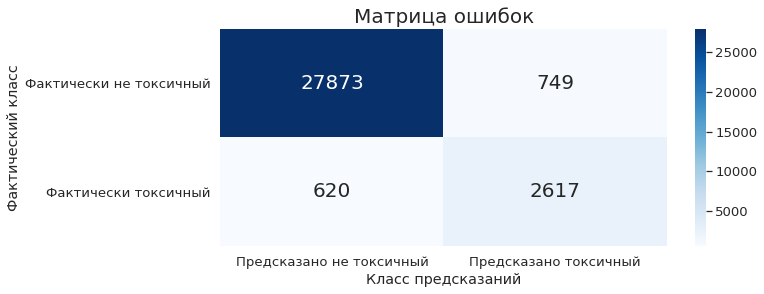

In [55]:
sns.set(font_scale=1.2)
plt.figure(figsize=(10,4))
    
sns.heatmap(cm_lr, annot=True, fmt='g', cmap="Blues",xticklabels=cm_df_lr.columns, yticklabels=cm_df_lr.index, annot_kws={"size": 20})
plt.title("Матрица ошибок", size=20)
plt.xlabel('Класс предсказаний')
plt.ylabel('Фактический класс');

In [56]:
def scoring(fitted_model):
    test_pred = fitted_model.predict(features_test)
    test_f1 = f1_score(y_test_final, test_pred)
    
    print('F1 на тестовой: {:.3f}'.format(test_f1))

In [57]:
scoring(lr_m)

F1 на тестовой: 0.793


Метрики логистической регресии
ROC AUC: 0.9726395948926347
F1: 0.7926699984855369



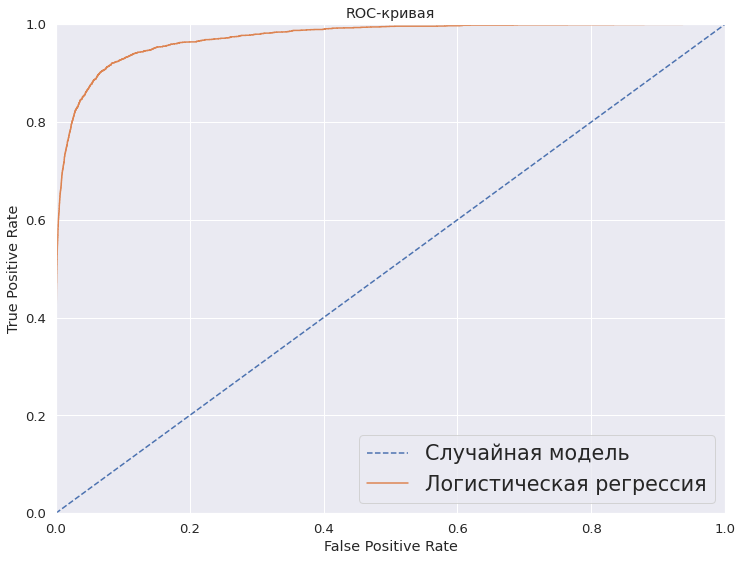

In [58]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')

probabilities_test = lr_m.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr_final, tpr_final, thresholds = roc_curve(y_test_final, probabilities_one_test)
predict_test = lr_m.predict(features_test)
plt.plot(fpr_final, tpr_final, label='Логистическая регрессия')
print('Метрики логистической регресии')
print('ROC AUC:', roc_auc_score(y_test_final, probabilities_one_test))
print('F1:', f1_score(y_test_final, predict_test))
print()

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

В ходе работы над проектом был обработан датасет с комментариями на английском языке, где нужно было определить, негативный отзыв или нет.

В отзывах присутствовал дисбаланс классов: соотношение положительных комментариев к отрицательным было равно 1:9
Подготовленны данные обучения на моделях. Для приведения текстов к векторному виду были пременены методы:

- очистка и лемматизация
- TF - IDF векторизация

Выбран способ баланса классов и поделены данные на обучающую и тестовою выборку.
Обучены модели и выбраны лучшие из них на валидационной выборке.
Показаны параметры качества моделей, а также графики для наглядности.

Исходные данные обладают большим количеством признаков. Созданных столбцов больше, чем записей данных. Так как TF-IDF превращают текст в численные значения, лучшими моделями стали LogisticRegression и SGDClassifier. CatBoostClassifier может показать себя очень хорошо при долгом обучении на данных. В ходе тестов выяснилось, что данный классификатор тратит очень много времени на обучение, поэтому для сокращения сроков ему были выданы маленькие значения максимального количества построенных деревьев.

На тестовой выбоке по метрике F1 лучше всего себя показала Логистическая регрессия. Данная модель обладает лучшими показателями по матрице ошибок. Это говорит нам, что токсичные комментарии находятся лучше.


На тестовой выборке модель логистическая регрессия показала - **0.793**, что подходит под требования задачи.

В сравнении участвовали модели логистической регрессии и модель градиентного бустинга SGD. Лучше всего проявила себя модель Логистической регрессии с гиперпараметрами

- 'C': 10, 
- 'class_weight': {'balanced'}.

TfidfVectorizer
- ngram_range=(1,3),
- min_df=3, 
- max_df=0.9,
- use_idf=1,
- smooth_idf=1,
- sublinear_tf=1.